In [1]:
import tensorflow as tf
import csgd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import DataSet
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = \
    cifar10.load_data()
train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()
train_data = DataSet(train_images, train_labels, dtype=tf.float32, reshape=False)
test_data = DataSet(test_images, test_labels, dtype=tf.float32, reshape=False)

In [3]:
def cifar10_model(optimizer, learning_rate):
    """ Build CIFAR10 model """
    tf.reset_default_graph()

    # Build NN
    x = tf.placeholder(tf.float32, [None, 32, 32, 3], 'input')
    y = tf.placeholder(tf.int32, [None,], 'labels')
    y_one_hot = tf.one_hot(indices=tf.cast(y, tf.int32), depth=10)
    out = tf.contrib.layers.conv2d(x, 64, 5)
    out = tf.contrib.layers.max_pool2d(out, 2)
    out = tf.contrib.layers.conv2d(out, 128, 3)
    out = tf.contrib.layers.max_pool2d(out, 2)
    out = tf.contrib.layers.conv2d(out, 256, 3)
    out = tf.contrib.layers.max_pool2d(out, 2)
    out = tf.contrib.layers.flatten(out)
    out = tf.contrib.layers.fully_connected(out, 1024)
    out = tf.contrib.layers.fully_connected(out, 256)
    out = tf.contrib.layers.fully_connected(out, 10, activation_fn=None)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_one_hot, logits=out))
    correct_prediction = tf.equal(tf.cast(tf.argmax(out, 1), tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Optimizer
    opt = optimizer(learning_rate=learning_rate)
    train_step = opt.minimize(loss)

    # Session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    def loss_and_acc(data, max_batch=1000):
        """ Return train/test loss/acc """
        ptr = 0
        l_sum, a_sum = 0, 0
        size = data.images.shape[0]
        while ptr < size:
            end = min(ptr+max_batch, size)
            feed_batch = {x: data.images[ptr:end],
                          y: data.labels[ptr:end]}
            l, a = sess.run([loss, accuracy], feed_batch)
            l_sum += (end-ptr)*l
            a_sum += (end-ptr)*a
            ptr = end
        return l_sum/size, a_sum/size 

    def train():
        """ Run train step """
        x_batch, y_batch = train_data.next_batch(100)
        feed_batch = {x: x_batch, y: y_batch}
        sess.run(train_step, feed_batch)
    
    return {
        'loss_and_acc': loss_and_acc,
        'train': train,
        'opt': opt,
        'sess': sess
    }

def run_model(model, num_iter=100000, num_out=200):
    """ Run model """
    chunk_size = num_iter // num_out
    assert chunk_size >= 1
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for t in range(num_iter):
        if t % chunk_size == 0:
            print('Epoch: ', t//chunk_size)
            temp1 = model['loss_and_acc'](train_data)
            temp2 = model['loss_and_acc'](test_data)
            train_losses.append(temp1[0])
            train_accs.append(temp1[1])
            test_losses.append(temp2[0])
            test_accs.append(temp2[1])
        model['train']()
    return np.asarray(train_losses), np.asarray(train_accs), \
            np.asarray(test_losses), np.asarray(test_accs)
        

def learning_rate_iterator(low, high, num):
    """ 
    Generate learning rate 
    Grid search on log-scale
    """
    values = np.linspace(low, high, num)
    values = np.power(10, values)
    for v in values:
        yield v

# cSGD

In [ ]:
num_test = 5
low, high = -3, 0
iterator = learning_rate_iterator(low, high, num_test)
csgd_train_losses, csgd_train_accs = [], []
csgd_test_losses, csgd_test_accs = [], []
csgd_lrs = []
for n in range(num_test):
    print('Test: ', n)
    learning_rate = next(iterator)
    print('Learning Rate: ', learning_rate)
    csgd_lrs.append(learning_rate)
    model = cifar10_model(csgd.CSGDOptimizer, learning_rate)
    train_l, train_a, test_l, test_a = run_model(model)
    model['sess'].close()
    csgd_train_losses.append(train_l)
    csgd_train_accs.append(train_a)
    csgd_test_losses.append(test_l)
    csgd_test_accs.append(test_a)
csgd_train_losses = np.asarray(csgd_train_losses)
csgd_train_accs = np.asarray(csgd_train_accs)
csgd_test_losses = np.asarray(csgd_test_losses)
csgd_test_accs = np.asarray(csgd_test_accs)
csgd_lrs = np.asarray(csgd_lrs)

Test:  0
Learning Rate:  0.001
Epoch:  0


Final acc:
Train:  [ 1.   1.   1.   1.   0.1]
Test:  [ 0.75119999  0.75030001  0.7502      0.7493      0.1       ]


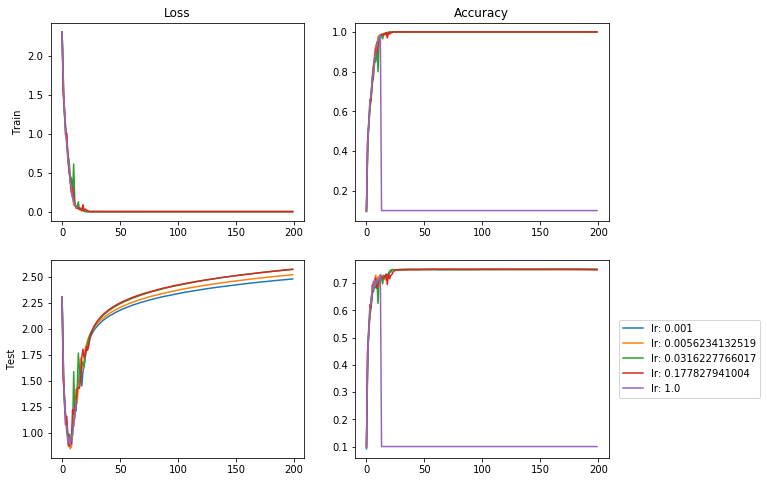

In [10]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for l in csgd_train_losses:
    ax[0,0].plot(l)
for a, lr in zip(csgd_train_accs, csgd_lrs):
    ax[0,1].plot(a, label='lr: '+str(lr))

for l in csgd_test_losses:
    ax[1,0].plot(l)
for a, lr in zip(csgd_test_accs, csgd_lrs):
    ax[1,1].plot(a, label='lr: '+str(lr))

ax[0,0].set_ylabel('Train')
ax[1,0].set_ylabel('Test')
ax[0,0].set_title('Loss')
ax[0,1].set_title('Accuracy')
    
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
print('Final acc:')
print('Train: ', csgd_train_accs[:,-1])
print('Test: ', csgd_test_accs[:,-1])

# SGD

In [ ]:
num_test = 5
low, high = -3, 0
iterator = learning_rate_iterator(low, high, num_test)
sgd_train_losses, sgd_train_accs = [], []
sgd_test_losses, sgd_test_accs = [], []
sgd_lrs = []
for n in range(num_test):
    print('Test: ', n)
    learning_rate = next(iterator)
    print('Learning Rate: ', learning_rate)
    sgd_lrs.append(learning_rate)
    model = cifar10_model(tf.train.GradientDescentOptimizer, learning_rate)
    train_l, train_a, test_l, test_a = run_model(model)
    model['sess'].close()
    sgd_train_losses.append(train_l)
    sgd_train_accs.append(train_a)
    sgd_test_losses.append(test_l)
    sgd_test_accs.append(test_a)
sgd_train_losses = np.asarray(sgd_train_losses)
sgd_train_accs = np.asarray(sgd_train_accs)
sgd_test_losses = np.asarray(sgd_test_losses)
sgd_test_accs = np.asarray(sgd_test_accs)
sgd_lrs = np.asarray(sgd_lrs)

Final acc:
Train:  [ 0.86454  1.       1.       1.       0.1    ]
Test:  [ 0.6618      0.6904      0.7232      0.74110001  0.1       ]


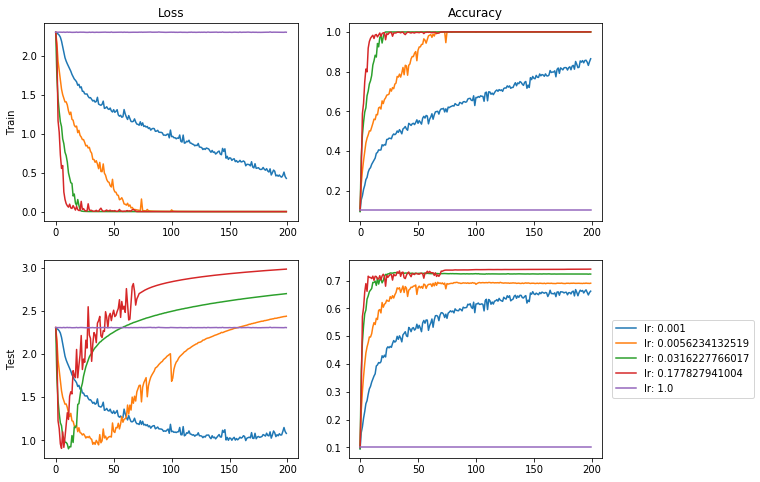

In [11]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for l in sgd_train_losses:
    ax[0,0].plot(l)
for a, lr in zip(sgd_train_accs, sgd_lrs):
    ax[0,1].plot(a, label='lr: '+str(lr))

for l in sgd_test_losses:
    ax[1,0].plot(l)
for a, lr in zip(sgd_test_accs, sgd_lrs):
    ax[1,1].plot(a, label='lr: '+str(lr))

ax[0,0].set_ylabel('Train')
ax[1,0].set_ylabel('Test')
ax[0,0].set_title('Loss')
ax[0,1].set_title('Accuracy')
   
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
print('Final acc:')
print('Train: ', sgd_train_accs[:,-1])
print('Test: ', sgd_test_accs[:,-1])

# Adam

In [ ]:
num_test = 5
low, high = -4, -1
iterator = learning_rate_iterator(low, high, num_test)
adam_train_losses, adam_train_accs = [], []
adam_test_losses, adam_test_accs = [], []
adam_lrs = []
for n in range(num_test):
    print('Test: ', n)
    learning_rate = next(iterator)
    print('Learning Rate: ', learning_rate)
    adam_lrs.append(learning_rate)
    model = cifar10_model(tf.train.AdamOptimizer, learning_rate)
    train_l, train_a, test_l, test_a = run_model(model)
    model['sess'].close()
    adam_train_losses.append(train_l)
    adam_train_accs.append(train_a)
    adam_test_losses.append(test_l)
    adam_test_accs.append(test_a)
adam_train_losses = np.asarray(adam_train_losses)
adam_train_accs = np.asarray(adam_train_accs)
adam_test_losses = np.asarray(adam_test_losses)
adam_test_accs = np.asarray(adam_test_accs)
adam_lrs = np.asarray(adam_lrs)

Final acc:
Train:  [ 1.       0.99786  0.9736   0.39294  0.1    ]
Test:  [ 0.75729999  0.747       0.6389      0.3838      0.1       ]


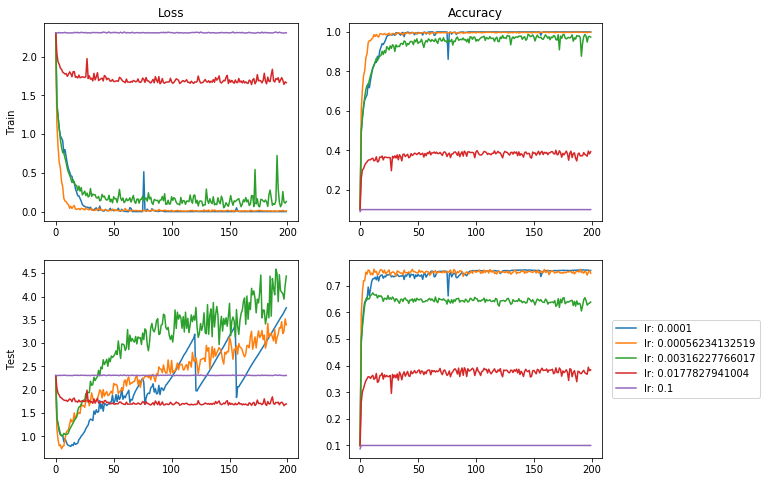

In [12]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for l in adam_train_losses:
    ax[0,0].plot(l)
for a, lr in zip(adam_train_accs, adam_lrs):
    ax[0,1].plot(a, label='lr: '+str(lr))

for l in adam_test_losses:
    ax[1,0].plot(l)
for a, lr in zip(adam_test_accs, adam_lrs):
    ax[1,1].plot(a, label='lr: '+str(lr))

ax[0,0].set_ylabel('Train')
ax[1,0].set_ylabel('Test')
ax[0,0].set_title('Loss')
ax[0,1].set_title('Accuracy')

plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
print('Final acc:')
print('Train: ', adam_train_accs[:,-1])
print('Test: ', adam_test_accs[:,-1])